In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
BASE_PATH = 'model_dataset'
TRAIN = 'training'
TEST = 'testing'
VAL = 'validation'
BATCH_SIZE = 15
TRAIN_PATH = os.path.join(BASE_PATH,TRAIN)
VAL_PATH = os.path.join(BASE_PATH, VAL)
TEST_PATH = os.path.join(BASE_PATH, TEST)
totalTrain = len(list(paths.list_images(TRAIN_PATH)))
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

In [3]:
trainAug = ImageDataGenerator(rotation_range=25,
                              zoom_range=0.1,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest")

valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [4]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(TRAIN_PATH,
                                        class_mode="categorical",
                                        target_size=(224, 224),
                                        color_mode="rgb",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE)
# initialize the validation generator
valGen = valAug.flow_from_directory(VAL_PATH,
                                    class_mode="categorical",
                                    target_size=(224, 224),
                                    color_mode="rgb",
                                    shuffle=False,
                                    batch_size=BATCH_SIZE)
# initialize the testing generator
testGen = valAug.flow_from_directory(TEST_PATH,
                                     class_mode="categorical",
                                     target_size=(224, 224),
                                     color_mode="rgb",
                                     shuffle=False,
                                     batch_size=BATCH_SIZE)

Found 2807 images belonging to 27 classes.
Found 299 images belonging to 27 classes.
Found 790 images belonging to 27 classes.


In [5]:
print(testGen.class_indices.keys())

dict_keys(['black dresses', 'black jeans', 'black pants', 'black shirts', 'black sweat shirts', 'black tops', 'black track pants', 'blue dresses', 'blue jeans', 'blue pants', 'blue shirts', 'blue sweat shirts', 'blue tops', 'blue track pants', 'green dresses', 'green shirts', 'green tops', 'pink tops', 'purple dresses', 'red dresses', 'red shirts', 'red tops', 'white dresses', 'white shirts', 'white tops', 'yellow dresses', 'yellow tops'])


In [ ]:
print("[INFO] preparing model...")
baseModel = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(27, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
INIT_LR = 1e-4
NUM_EPOCHS = 12
opt = Adam(lr=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print("[INFO] training model...")
H = model.fit_generator(
    trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=valGen,
    validation_steps=totalVal // BATCH_SIZE,
    epochs=NUM_EPOCHS)

In [ ]:
MODEL_PATH = os.path.sep.join(["output","resnet1"])
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,
	steps=(totalTest // BATCH_SIZE) + 1)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))
print("[INFO] saving model...")
model.save(MODEL_PATH, save_format="h5")

In [8]:
MODEL_PATH = os.path.sep.join(["output","resnet1"])
model = load_model(MODEL_PATH)
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,
	steps=(totalTest // BATCH_SIZE) + 1)

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))


[INFO] evaluating network...


C:\Users\evars\anaconda3\envs\tenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


                    precision    recall  f1-score   support

     black dresses       0.49      0.93      0.64        28
       black jeans       0.59      0.65      0.62        31
       black pants       0.42      0.36      0.38        28
      black shirts       0.67      0.47      0.55        30
black sweat shirts       0.61      0.65      0.63        26
        black tops       0.53      0.62      0.57        32
 black track pants       0.47      0.33      0.39        27
      blue dresses       0.62      0.48      0.54        27
        blue jeans       0.71      0.80      0.75        30
        blue pants       0.41      0.55      0.47        31
       blue shirts       0.56      0.50      0.53        30
 blue sweat shirts       0.57      0.53      0.55        30
         blue tops       0.43      0.52      0.47        29
  blue track pants       0.42      0.36      0.38        28
     green dresses       0.74      0.69      0.71        29
      green shirts       0.60      0.81

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas
cm = confusion_matrix(testGen.classes, predIdxs)

<AxesSubplot:>

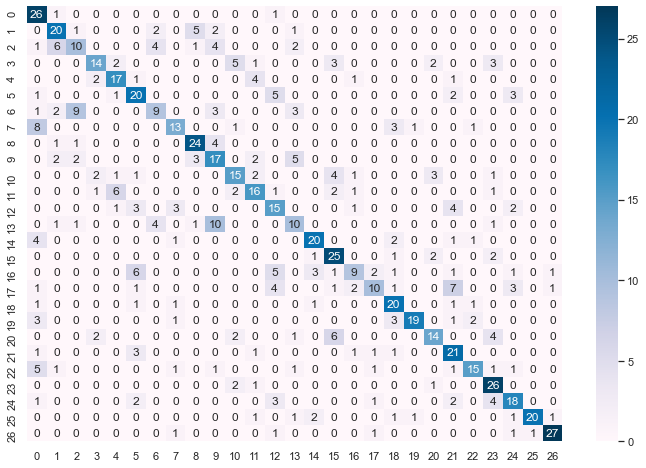

In [10]:
sns.set(font_scale=1)
plt.figure(figsize = (12,8))
sns.heatmap(cm,annot = True,cmap='PuBu')

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________